<a href="https://colab.research.google.com/github/JuniorTorresMTJ/FraudBoleto/blob/main/notebook/BoletoFraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
***
#DETECÇÃO DE FRAUDE DE BOLETO
***
***

- Existe algum padrão no comportamento dos fraudadores?-
- Esse dataset é suficiente para tirar alguma conclusão?
- Conseguimos fazer alguma “feature engineering” que nos auxilie a identificar os fraudadores?
- Como poderíamos identificá-los antes das denúncias?
- Consegue propor alguma sugestão do que é necessário ser feito para solucionar o problema?

#IMPORTAÇÃO DAS BIBLIOTECAS

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

#CARREGAMENTO DA BASE

In [3]:
df_boleto = pd.read_csv("https://raw.githubusercontent.com/JuniorTorresMTJ/FraudBoleto/main/Data/dataset_case_boleto.csv", sep=";")
df_boleto

,mes_ref,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude
0,01/03/2020,5e74d202d1498c5bdf8aafe3,cnpj,6000,"4884,61",63500,"2122,83",10,13,0,35,11,0,0
1,01/03/2020,5e78dafeb5ac867c7e85eb5e,cnpj,1800,1800,3600,0,0,2,0,0,11,0,0
2,01/03/2020,5e73e21359193c2f123c1076,cnpj,"159,9","104,9","209,8","77,78",0,2,0,14,11,0,0
3,01/04/2020,5e7262c49d55ea5dbea59d57,cnpj,600,600,1800,0,0,3,0,18,11,0,0
4,01/04/2020,5e610d9f66945c0f82dd357f,cnpj,2941,"1764,6",8823,"657,63",2,5,0,65,12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9272,01/11/2020,5fa6013aec647c00160a173b,cpf,50,50,50,0,0,1,0,0,2,0,1
9273,01/11/2020,5fc3ed1659018400162a83ad,cpf,10,10,10,0,1,1,0,0,3,0,0
9274,01/10/2020,5f6f796ccff5532d540c6f58,cpf,160,160,160,0,0,1,0,0,5,0,0
9275,01/12/2020,5ebd605d4c4cb062ab6b3c66,cnpj,600,600,600,0,0,1,0,0,9,0,0


#FUNÇÕES


In [4]:
def get_iqr_values(df_in, col_name):
    median = df_in[col_name].median()
    q1 = df_in[col_name].quantile(0.25) # 25th percentile / 1st quartile
    q3 = df_in[col_name].quantile(0.75) # 7th percentile / 3rd quartile
    iqr = q3-q1 #Interquartile range
    minimum  = q1-1.5*iqr # The minimum value or the |- marker in the box plot
    maximum = q3+1.5*iqr # The maximum value or the -| marker in the box plot
    return median, q1, q3, iqr, minimum, maximum

def get_iqr_text(df_in, col_name):
    median, q1, q3, iqr, minimum, maximum = get_iqr_values(df_in, col_name)
    text = f"median={median:.2f}, q1={q1:.2f}, q3={q3:.2f}, iqr={iqr:.2f}, minimum={minimum:.2f}, maximum={maximum:.2f}"
    return text

def remove_outliers(df_in, col_name):
    _, _, _, _, minimum, maximum = get_iqr_values(df_in, col_name)
    df_out = df_in.loc[(df_in[col_name] > minimum) & (df_in[col_name] < maximum)]
    return df_out

def count_outliers(df_in, col_name):
    _, _, _, _, minimum, maximum = get_iqr_values(df_in, col_name)
    df_outliers = df_in.loc[(df_in[col_name] <= minimum) | (df_in[col_name] >= maximum)]
    return df_outliers.shape[0]

def box_and_whisker(df_in, col_name):
    title = get_iqr_text(df_in, col_name)
    sns.boxplot(df_in[col_name], color= color[0])
    plt.title(title)
    plt.show()

In [5]:
color =['#87B738',
        '#283610',
        '#ABCC73'] 

#LIMPEZA E TRANSFORMAÇÃO

In [6]:
df_boleto['max_valor_boleto'] = df_boleto['max_valor_boleto'].str.replace(',', '.')
df_boleto['avg_valor_boleto'] = df_boleto['max_valor_boleto'].str.replace(',', '.')
df_boleto['total_valor_boleto'] = df_boleto['max_valor_boleto'].str.replace(',', '.')
df_boleto['valor_boleto_stdv'] = df_boleto['max_valor_boleto'].str.replace(',', '.')

In [7]:
df_boleto['valor_boleto_stdv']

0        6000
1        1800
2       159.9
3         600
4        2941
        ...  
9272       50
9273       10
9274      160
9275      600
9276       60
Name: valor_boleto_stdv, Length: 9277, dtype: object

In [8]:
df_boleto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9277 entries, 0 to 9276
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   mes_ref               9277 non-null   object
 1   company_id            9277 non-null   object
 2   tipo_doc              9277 non-null   object
 3   max_valor_boleto      9277 non-null   object
 4   avg_valor_boleto      9277 non-null   object
 5   total_valor_boleto    9277 non-null   object
 6   valor_boleto_stdv     9277 non-null   object
 7   qtd_boleto_pago       9277 non-null   int64 
 8   qtd_boleto_total      9277 non-null   int64 
 9   qtd_boleto_estorno    9277 non-null   int64 
 10  qnt_cc_total          9277 non-null   int64 
 11  tempo_credenciamento  9277 non-null   int64 
 12  conta_bnk_repetida    9277 non-null   int64 
 13  fraude                9277 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 1014.8+ KB


In [9]:
df_boleto['max_valor_boleto'] = df_boleto['max_valor_boleto'].astype(float)
df_boleto['avg_valor_boleto'] = df_boleto['avg_valor_boleto'].astype(float)
df_boleto['total_valor_boleto'] = df_boleto['total_valor_boleto'].astype(float)
df_boleto['valor_boleto_stdv'] = df_boleto['valor_boleto_stdv'].astype(float)

##Cada id uma linha

In [10]:
df_boleto['company_id'].value_counts()

5e1c738d7268a016d9e71108    14
5e7cbc38f2eebc591d523154    13
5e7e508f03cfe831e3703c26    13
5e7507e20a8d7971d0698d79    13
5e7cc3118dc5042cae4e94b5    13
                            ..
5ffe3593f8ada7001029899a     1
5efbdc66428caf2e22d2efa2     1
5f7ed2541978be65bdb844d2     1
60042ac55c2d19001626ba7b     1
6038f8382816470011720ff9     1
Name: company_id, Length: 4960, dtype: int64

<img src="https://raw.githubusercontent.com/Giatroo/BeeData_GroupBy-in-Pandas/main/split-apply-combine.jpeg" alt="win" width="800"/>

In [11]:
df_boleto.query('company_id =="5e78c7d101e84d486076b16f"')

,mes_ref,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude
168,01/03/2020,5e78c7d101e84d486076b16f,cnpj,199.99,199.99,199.99,199.99,5,19,0,0,11,0,0
230,01/04/2020,5e78c7d101e84d486076b16f,cnpj,199.90,199.90,199.90,199.90,2,14,0,2,11,0,0
377,01/08/2020,5e78c7d101e84d486076b16f,cnpj,531.17,531.17,531.17,531.17,10,14,0,6,11,0,0
1128,01/07/2020,5e78c7d101e84d486076b16f,cnpj,285.55,285.55,285.55,285.55,9,20,0,1,11,0,0
1316,01/10/2020,5e78c7d101e84d486076b16f,cnpj,274.97,274.97,274.97,274.97,18,27,0,14,11,0,0
1616,01/11/2020,5e78c7d101e84d486076b16f,cnpj,549.94,549.94,549.94,549.94,14,29,0,8,11,0,0
2077,01/06/2020,5e78c7d101e84d486076b16f,cnpj,275.80,275.80,275.80,275.80,1,2,0,1,11,0,0
2859,01/05/2020,5e78c7d101e84d486076b16f,cnpj,99.00,99.00,99.00,99.00,1,4,0,8,11,0,0
2896,01/03/2021,5e78c7d101e84d486076b16f,cnpj,373.60,373.60,373.60,373.60,2,3,0,1,11,0,0
3746,01/09/2020,5e78c7d101e84d486076b16f,cnpj,285.55,285.55,285.55,285.55,15,30,0,0,11,0,0


In [12]:
df_boleto_clean = df_boleto.groupby(['company_id', 'tipo_doc','conta_bnk_repetida','fraude']).mean().reset_index()

In [13]:
df_amount= df_boleto.groupby(['company_id']).size().reset_index()
df_amount = df_amount.rename(columns={0: "amount"})
df_amount

,company_id,amount
0,5e0eb0115e364024155a696c,1
1,5e0f70e84331ba63bb6a3eb0,9
2,5e1485a98e158b0d6cfc4df9,1
3,5e149751d9d52a271763c0e1,1
4,5e14ac4c6204025f8ec345a3,4
...,...,...
4955,60442a0bb22d6100118bc21a,1
4956,60444661b22d6100118bc276,1
4957,60444c6505b7f90019aa3e20,1
4958,60445669a8b6c8001136e544,1


In [14]:
df_amount.company_id.value_counts()

602e7f3c0c87fc00193821b3    1
600f64fa8dcddf0010cd3d81    1
5f9ce94c1bfb140018bf2eee    1
5e751b9cd1498c5bdf8ab206    1
5e5f1d875775224e1065669a    1
                           ..
5eb03344c9543c6b87b6c5bc    1
5eb482581e7e63167e3ae99f    1
60396045b3b05e0011188c55    1
5fa6f76b2bd90000102039aa    1
6028ff390c87fc0019380bbf    1
Name: company_id, Length: 4960, dtype: int64

In [15]:
df_boleto_clean = df_boleto_clean.merge(df_amount, on='company_id')
df_boleto_clean

,company_id,tipo_doc,conta_bnk_repetida,fraude,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,amount
0,5e0eb0115e364024155a696c,cpf,0,0,597.950000,597.950000,597.950000,597.950000,0.000000,4.000000,0.0,3.000000,14.0,1
1,5e0f70e84331ba63bb6a3eb0,cnpj,0,0,831.977778,831.977778,831.977778,831.977778,1.666667,2.333333,0.0,11.888889,14.0,9
2,5e1485a98e158b0d6cfc4df9,cpf,0,0,792.930000,792.930000,792.930000,792.930000,0.000000,1.000000,0.0,0.000000,14.0,1
3,5e149751d9d52a271763c0e1,cnpj,0,0,2399.000000,2399.000000,2399.000000,2399.000000,0.000000,1.000000,0.0,2.000000,14.0,1
4,5e14ac4c6204025f8ec345a3,cnpj,0,0,396.150000,396.150000,396.150000,396.150000,1.750000,3.000000,0.0,46.750000,14.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4955,60442a0bb22d6100118bc21a,cnpj,0,0,10020.000000,10020.000000,10020.000000,10020.000000,0.000000,2.000000,0.0,0.000000,0.0,1
4956,60444661b22d6100118bc276,cnpj,0,0,12090.000000,12090.000000,12090.000000,12090.000000,0.000000,2.000000,0.0,0.000000,0.0,1
4957,60444c6505b7f90019aa3e20,cnpj,0,0,26541.710000,26541.710000,26541.710000,26541.710000,0.000000,2.000000,0.0,0.000000,0.0,1
4958,60445669a8b6c8001136e544,cnpj,0,0,17681.370000,17681.370000,17681.370000,17681.370000,0.000000,1.000000,0.0,0.000000,0.0,1


#ANÁLISE EXPLORATÓRIA

##Quantidade de Dados Nulos

In [16]:
df_boleto_clean.isnull().sum()

company_id              0
tipo_doc                0
conta_bnk_repetida      0
fraude                  0
max_valor_boleto        0
avg_valor_boleto        0
total_valor_boleto      0
valor_boleto_stdv       0
qtd_boleto_pago         0
qtd_boleto_total        0
qtd_boleto_estorno      0
qnt_cc_total            0
tempo_credenciamento    0
amount                  0
dtype: int64

In [17]:
df_boleto_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4960 entries, 0 to 4959
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   company_id            4960 non-null   object 
 1   tipo_doc              4960 non-null   object 
 2   conta_bnk_repetida    4960 non-null   int64  
 3   fraude                4960 non-null   int64  
 4   max_valor_boleto      4960 non-null   float64
 5   avg_valor_boleto      4960 non-null   float64
 6   total_valor_boleto    4960 non-null   float64
 7   valor_boleto_stdv     4960 non-null   float64
 8   qtd_boleto_pago       4960 non-null   float64
 9   qtd_boleto_total      4960 non-null   float64
 10  qtd_boleto_estorno    4960 non-null   float64
 11  qnt_cc_total          4960 non-null   float64
 12  tempo_credenciamento  4960 non-null   float64
 13  amount                4960 non-null   int64  
dtypes: float64(9), int64(3), object(2)
memory usage: 581.2+ KB


##Dados balanceados?

In [18]:
balanced = [df_boleto_clean['fraude'].value_counts()[0], df_boleto_clean['fraude'].value_counts()[1]]

In [19]:
fig = go.Figure(go.Bar (x = ['Não Fraude', 'Fraude'],
                        y = balanced,
                        marker = dict(color = [color[0], color[1]],
)))
fig.update_layout(
    title="""Balanceamento da Variável Target
            """,
    title_font_size=22,
    font_size=13,
    plot_bgcolor='white',
    legend_x=0.99, legend_xanchor='right', legend_font_size=18,
    hovermode='x',
    bargap=0.15,
    width=800, height=500
)
fig.update_yaxes(title = 'Quantidade')
fig.show()

##Variáveis numericas

In [20]:
numerical_features = df_boleto.drop(['fraude','conta_bnk_repetida'], axis=1).select_dtypes(include = np.number).columns

In [21]:
numerical_features 

Index(['max_valor_boleto', 'avg_valor_boleto', 'total_valor_boleto',
       'valor_boleto_stdv', 'qtd_boleto_pago', 'qtd_boleto_total',
       'qtd_boleto_estorno', 'qnt_cc_total', 'tempo_credenciamento'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb11f1fa690>,
      dtype=object)

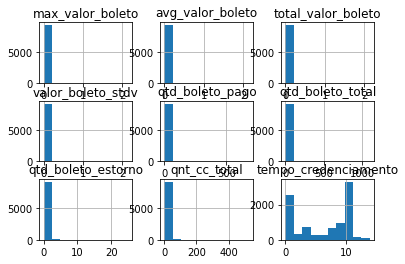

In [22]:
df_boleto[numerical_features].hist()

In [23]:
df_fraud = df_boleto.query('fraude == 1')
df_no_fraud = df_boleto.query('fraude == 0')

##Revomendo Outliers

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



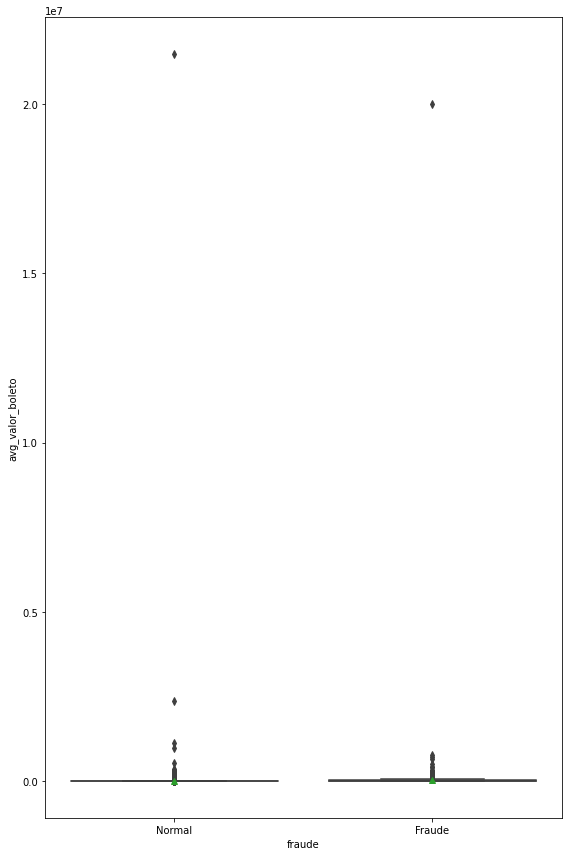

In [24]:
fig , ax = plt.subplots(figsize=(8, 12), sharex=True)
sns.boxplot(df_boleto.fraude, df_boleto.avg_valor_boleto, showmeans=True, ax=ax, orient='v')
plt.xticks([0, 1],['Normal', 'Fraude'])
plt.tight_layout();

5357, 8785

In [25]:
df_boleto.query('avg_valor_boleto > 10000000.0')

,mes_ref,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude
5357,01/01/2021,5f2806ac630047377469fc39,cpf,20000000.00,20000000.00,20000000.00,20000000.00,0,3,0,0,5,0,1
8785,01/06/2020,5ed79c02aac2f87ee2f8f0d4,cpf,21474836.47,21474836.47,21474836.47,21474836.47,0,2,0,0,8,0,0


In [26]:
df_boleto = df_boleto.drop([5357, 8785])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



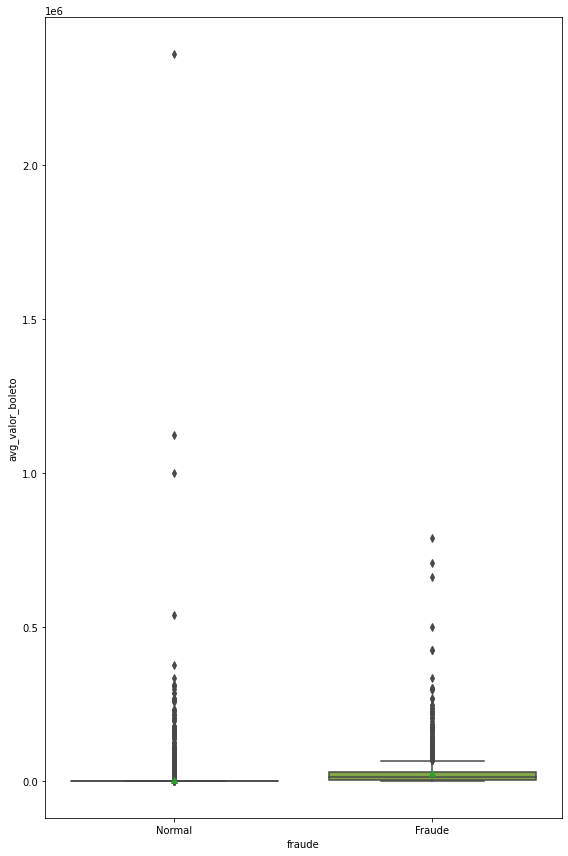

In [27]:
fig , ax = plt.subplots(figsize=(8, 12), sharex=True)
sns.boxplot(df_boleto.fraude, df_boleto.avg_valor_boleto, showmeans=True, ax=ax, orient='v', color= color[0])
plt.xticks([0, 1],['Normal', 'Fraude'])
plt.tight_layout();

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



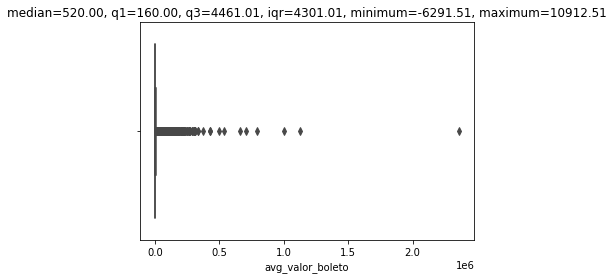

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



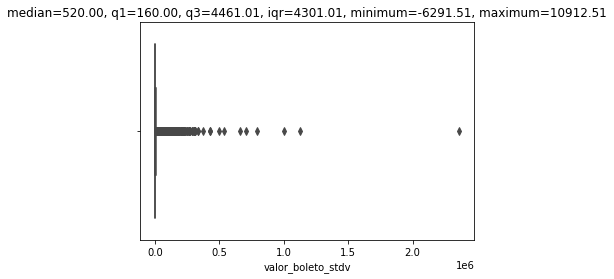

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



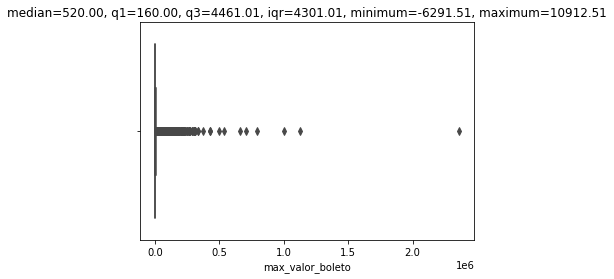

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



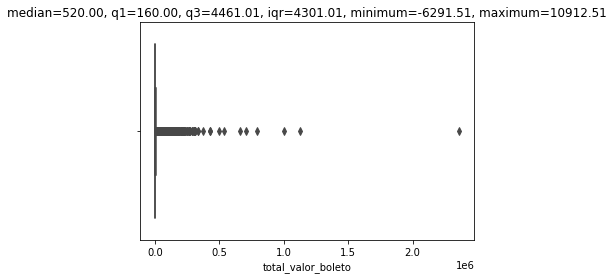

In [28]:
box_and_whisker(df_boleto, 'avg_valor_boleto')
box_and_whisker(df_boleto, 'valor_boleto_stdv')
box_and_whisker(df_boleto, 'max_valor_boleto')
box_and_whisker(df_boleto, 'total_valor_boleto')

In [29]:
print(f" A coluna valor_boleto_stdv tem {count_outliers(df_boleto, 'valor_boleto_stdv')} outliers")
print(f" A coluna total_valor_boleto tem {count_outliers(df_boleto, 'total_valor_boleto')} outliers")
print(f" A coluna avg_valor_boleto tem {count_outliers(df_boleto, 'avg_valor_boleto')} outliers")
print(f" A coluna max_valor_boleto tem {count_outliers(df_boleto, 'max_valor_boleto')} outliers")

 A coluna valor_boleto_stdv tem 1419 outliers
 A coluna total_valor_boleto tem 1419 outliers
 A coluna avg_valor_boleto tem 1419 outliers
 A coluna max_valor_boleto tem 1419 outliers


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



rows before removing: 9275
rows after removing: 5748


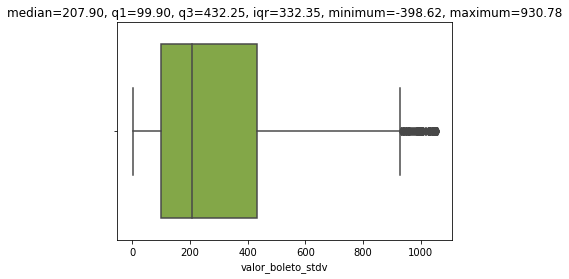

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



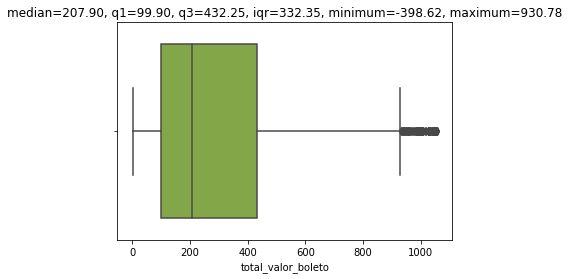

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



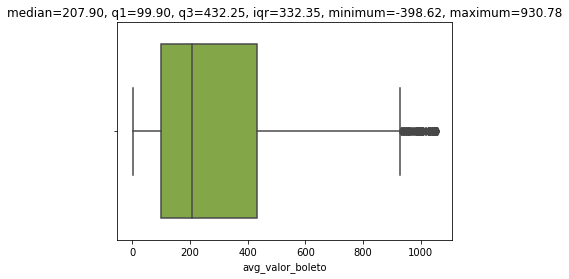

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



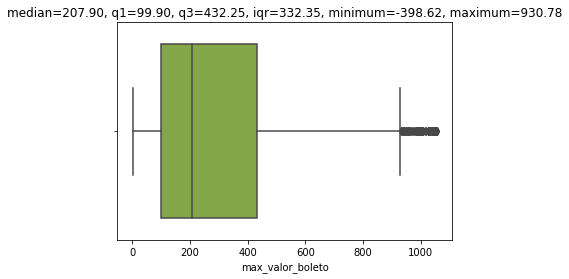

In [30]:
# %% Remove the outliers
print(f"rows before removing: {df_boleto.shape[0]}")
df_boleto = remove_outliers(df_boleto, 'valor_boleto_stdv')
df_boleto = remove_outliers(df_boleto, 'total_valor_boleto')
df_boleto = remove_outliers(df_boleto, 'avg_valor_boleto')
df_boleto = remove_outliers(df_boleto, 'max_valor_boleto')
print(f"rows after removing: {df_boleto.shape[0]}")

# Let's have a look at the end-result. Here is something very strange though, our data still appears to have outliers!
box_and_whisker(df_boleto, 'valor_boleto_stdv')
box_and_whisker(df_boleto, 'total_valor_boleto')
box_and_whisker(df_boleto, 'avg_valor_boleto')
box_and_whisker(df_boleto, 'max_valor_boleto')

##Separando os conjuntos de dados

In [31]:
df_fraud = df_boleto.query('fraude == 1')
df_no_fraud = df_boleto.query('fraude == 0')

##Análise das variáveis

In [32]:
df_fraud.describe()

,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.0,142.000000,142.000000,142.0
mean,565.685211,565.685211,565.685211,565.685211,0.450704,5.612676,1.767606,0.0,2.640845,0.676056,1.0
std,282.496700,282.496700,282.496700,282.496700,2.454053,9.060747,2.191749,0.0,2.015337,0.469635,0.0
min,3.000000,3.000000,3.000000,3.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,1.0
25%,479.407500,479.407500,479.407500,479.407500,0.000000,2.000000,0.000000,0.0,1.000000,0.000000,1.0
50%,599.795000,599.795000,599.795000,599.795000,0.000000,4.000000,1.000000,0.0,4.000000,1.000000,1.0
75%,700.000000,700.000000,700.000000,700.000000,0.000000,6.000000,4.000000,0.0,4.000000,1.000000,1.0
max,1057.000000,1057.000000,1057.000000,1057.000000,24.000000,89.000000,9.000000,0.0,8.000000,1.000000,1.0


In [33]:
df_no_fraud.describe()

,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude
count,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.0
mean,284.693007,284.693007,284.693007,284.693007,4.633607,7.370318,0.008741,8.498751,8.864788,0.008027,0.0
std,246.313423,246.313423,246.313423,246.313423,12.956191,21.110141,0.133952,21.392402,3.047044,0.089242,0.0
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,99.300000,99.300000,99.300000,99.300000,0.000000,1.000000,0.000000,0.000000,8.000000,0.000000,0.0
50%,200.000000,200.000000,200.000000,200.000000,1.000000,2.000000,0.000000,2.000000,10.000000,0.000000,0.0
75%,407.675000,407.675000,407.675000,407.675000,3.000000,5.000000,0.000000,8.000000,11.000000,0.000000,0.0
max,1057.000000,1057.000000,1057.000000,1057.000000,189.000000,423.000000,4.000000,528.000000,14.000000,1.000000,0.0


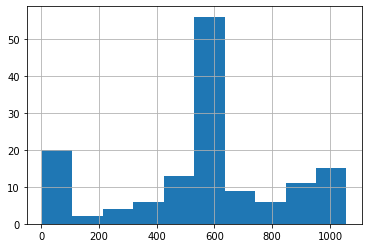

In [34]:
df_fraud['max_valor_boleto'].hist()

In [35]:
df_fraud['company_id'].value_counts()

6009fe6293e19e00106dc3b5    3
5f4d09dbca72203729f5aee3    2
5fc6e59a83ca9b0010788e3b    2
5f3497c9ca191809dce38b01    2
5f57841ef11fce644e4eba0c    2
                           ..
5f6a44748976ca3c38eea6e6    1
5f63f6787401642581047861    1
5f63a7ef250fb74955f94049    1
5fe22319f9c78500173b70ab    1
5f6ca67de439c23e2012acd8    1
Name: company_id, Length: 125, dtype: int64

In [36]:
df_fraud.query('company_id == "6009fe6293e19e00106dc3b5" ')

,mes_ref,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude
2375,01/03/2021,6009fe6293e19e00106dc3b5,cpf,700.00,700.00,700.00,700.00,0,2,0,0,0,0,1
4730,01/02/2021,6009fe6293e19e00106dc3b5,cpf,500.00,500.00,500.00,500.00,0,13,8,0,0,0,1
9197,01/01/2021,6009fe6293e19e00106dc3b5,cpf,627.67,627.67,627.67,627.67,0,9,2,0,0,0,1


In [37]:
df_fraud['conta_bnk_repetida'].value_counts(normalize=True)

1    0.676056
0    0.323944
Name: conta_bnk_repetida, dtype: float64

In [38]:
df_no_fraud['conta_bnk_repetida'].value_counts(normalize=True)

0    0.991973
1    0.008027
Name: conta_bnk_repetida, dtype: float64

In [39]:
df_no_fraud['tempo_credenciamento'].value_counts(normalize=True)

11    0.345701
10    0.187656
9     0.154656
8     0.071709
4     0.033535
0     0.033357
3     0.030146
7     0.028362
12    0.023011
6     0.022654
5     0.020335
1     0.019800
2     0.011238
14    0.008919
13    0.008919
Name: tempo_credenciamento, dtype: float64

In [40]:
df_fraud['tempo_credenciamento'].value_counts(normalize=True)

4    0.394366
0    0.239437
1    0.126761
2    0.098592
5    0.091549
8    0.021127
3    0.021127
7    0.007042
Name: tempo_credenciamento, dtype: float64

In [41]:
df_no_fraud['qnt_cc_total'].value_counts(normalize=True)

0      0.380485
1      0.099358
2      0.064930
3      0.055833
4      0.043168
         ...   
117    0.000178
113    0.000178
105    0.000178
93     0.000178
161    0.000178
Name: qnt_cc_total, Length: 134, dtype: float64

In [42]:
df_fraud['qnt_cc_total'].value_counts(normalize=True)

0    1.0
Name: qnt_cc_total, dtype: float64

In [43]:
cc_maior_1_fraud = df_fraud.query('qnt_cc_total >= 1')['qnt_cc_total'].value_counts().sum()
cc_maior_0_fraud = df_fraud.query('qnt_cc_total == 0')['qnt_cc_total'].value_counts().sum()
cc_maior_1_fraud, cc_maior_0_fraud

(0, 142)

In [71]:
a = [cc_maior_1_fraud, cc_maior_0_fraud]
fig = go.Figure(go.Bar (x = ['Maior que 1', 'Nenhum'],
                        y = a,
                        marker = dict(color = [color[0], color[1]],
)),             
)
fig.update_layout(
    title="""Transções no <b>Cartão de Crédito</b> <br>( Fraude)
            """,
    title_font_size=22,
    font_size=13,
    plot_bgcolor='white',
    legend_x=0.99, legend_xanchor='right', legend_font_size=18,
    hovermode='x',
    bargap=0.15,
    width=700, height=450
)

fig.update_xaxes(
    mirror=True, ticks='outside', showline=True, linewidth=1, linecolor='gray')
fig.update_yaxes(
    mirror=True, ticks='outside', showline=True, linewidth=1, linecolor='grey',
    )

fig.update_xaxes(type = 'category', title = 'Transações')
fig.update_yaxes(title = 'Quantidade')
fig.show()

In [45]:
cc_maior_1 = df_no_fraud.query('qnt_cc_total >= 1')['qnt_cc_total'].value_counts().sum()
cc_maior_0 = df_no_fraud.query('qnt_cc_total == 0')['qnt_cc_total'].value_counts().sum()
cc_maior_1, cc_maior_0

(3473, 2133)

In [46]:
a = [cc_maior_1, cc_maior_0]
fig = make_subplots(rows=1, cols=2)

fig = go.Figure(go.Bar (x = ['Maior que 1', 'Nenhum'],
                        y = a,
                        marker = dict(color = [color[0], color[1]],
)),             
)

fig.update_layout(
    title="""Transções no <b>Cartão de Crédito</b> <br>(Não Fraude)
            """,
    title_font_size=22,
    font_size=13,
    plot_bgcolor='white',
    legend_x=0.99, legend_xanchor='right', legend_font_size=18,
    hovermode='x',
    bargap=0.15,
    width=700, height=450
)
fig.update_xaxes(
    mirror=True, ticks='outside', showline=True, linewidth=1, linecolor='gray')
fig.update_yaxes(
    mirror=True, ticks='outside', showline=True, linewidth=1, linecolor='grey',
    )
fig.update_xaxes(type = 'category', title = 'Transações')
fig.update_yaxes(title = 'Quantidade')


In [48]:
cc_maior_1_fraud = df_fraud.query('qnt_cc_total >= 1')['qnt_cc_total'].value_counts().sum()
cc_maior_0_fraud = df_fraud.query('qnt_cc_total == 0')['qnt_cc_total'].value_counts().sum()
cc_maior_1_fraud, cc_maior_0_fraud

(0, 142)

##Boletos Estornados

In [49]:
df_fraud['qtd_boleto_estorno'].value_counts(normalize=True)

0    0.471831
4    0.183099
1    0.119718
2    0.105634
6    0.049296
5    0.028169
8    0.014085
3    0.014085
9    0.007042
7    0.007042
Name: qtd_boleto_estorno, dtype: float64

In [50]:
Qtd_estorno_maior_1_fraud = df_fraud.query('qtd_boleto_estorno >= 1')['qtd_boleto_estorno'].value_counts().sum()
Qtd_estorno_maior_0_fraud = df_fraud.query('qtd_boleto_estorno == 0')['qtd_boleto_estorno'].value_counts().sum()
Qtd_estorno_maior_1_fraud, Qtd_estorno_maior_0_fraud

(75, 67)

In [51]:
a = [Qtd_estorno_maior_1_fraud , Qtd_estorno_maior_0_fraud]
fig = go.Figure(go.Bar (x = ['Maior que 1', 'Nenhum'],
                        y = a,
                        marker = dict(color = [color[0], color[1]],
)),             
)
fig.update_layout(
    title="""Porcentagem de Boletos <b>Extornados</b><br>(Fraude)
            """,
    title_font_size=22,
    font_size=13,
    plot_bgcolor='white',
    legend_x=0.99, legend_xanchor='right', legend_font_size=18,
    hovermode='x',
    bargap=0.15,
    width=700, height=450
)

fig.update_xaxes(
    mirror=True, ticks='outside', showline=True, linewidth=1, linecolor='gray')
fig.update_yaxes(
    mirror=True, ticks='outside', showline=True, linewidth=1, linecolor='grey',
    )


fig.update_xaxes(type = 'category', title = 'Estornos')
fig.update_yaxes(title = 'Quantidade')
fig.show()

In [52]:
Qtd_estorno_maior_1 = df_no_fraud.query('qtd_boleto_estorno >= 1')['qtd_boleto_estorno'].value_counts().sum()
Qtd_estorno_maior_0 = df_no_fraud.query('qtd_boleto_estorno == 0')['qtd_boleto_estorno'].value_counts().sum()
Qtd_estorno_maior_1, Qtd_estorno_maior_0

(35, 5571)

In [53]:
a = [Qtd_estorno_maior_1 , Qtd_estorno_maior_0]
fig = go.Figure(go.Bar (x = ['Maior que 1', 'Nenhum'],
                        y = a,
                        marker = dict(color = [color[0], color[1]],
)),             
)
fig.update_layout(
    title="""Porcentagem de Boletos <b>Extornados</b><br>(Não Fraude)
            """,
    title_font_size=22,
    font_size=13,
    plot_bgcolor='white',
    legend_x=0.99, legend_xanchor='right', legend_font_size=18,
    hovermode='x',
    bargap=0.15,
    width=700, height=450
)

fig.update_xaxes(
    mirror=True, ticks='outside', showline=True, linewidth=1, linecolor='gray')
fig.update_yaxes(
    mirror=True, ticks='outside', showline=True, linewidth=1, linecolor='grey',
    )


fig.update_xaxes(type = 'category', title = 'Estornos')
fig.update_yaxes(title = 'Quantidade')
fig.show()

In [54]:
df_fraud['mes_ref'].value_counts(normalize=True)

01/09/2020    0.309859
01/01/2021    0.197183
01/02/2021    0.190141
01/12/2020    0.105634
01/11/2020    0.063380
01/10/2020    0.049296
01/08/2020    0.042254
01/03/2021    0.035211
01/05/2020    0.007042
Name: mes_ref, dtype: float64

In [55]:
df_no_fraud['qtd_boleto_pago'].value_counts(normalize=True)

1      0.313949
0      0.280949
2      0.120050
3      0.061184
4      0.040492
         ...   
109    0.000178
89     0.000178
77     0.000178
73     0.000178
171    0.000178
Name: qtd_boleto_pago, Length: 105, dtype: float64

In [56]:
df_fraud['qtd_boleto_pago'].value_counts(normalize=True)

0     0.894366
1     0.063380
2     0.014085
24    0.007042
14    0.007042
8     0.007042
5     0.007042
Name: qtd_boleto_pago, dtype: float64

In [57]:
df_no_fraud['tipo_doc'].value_counts(normalize=True)

cnpj    0.71031
cpf     0.28969
Name: tipo_doc, dtype: float64

In [58]:
df_fraud['tipo_doc'].value_counts(normalize=True)

cpf     0.93662
cnpj    0.06338
Name: tipo_doc, dtype: float64

In [59]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 161 to 9272
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mes_ref               142 non-null    object 
 1   company_id            142 non-null    object 
 2   tipo_doc              142 non-null    object 
 3   max_valor_boleto      142 non-null    float64
 4   avg_valor_boleto      142 non-null    float64
 5   total_valor_boleto    142 non-null    float64
 6   valor_boleto_stdv     142 non-null    float64
 7   qtd_boleto_pago       142 non-null    int64  
 8   qtd_boleto_total      142 non-null    int64  
 9   qtd_boleto_estorno    142 non-null    int64  
 10  qnt_cc_total          142 non-null    int64  
 11  tempo_credenciamento  142 non-null    int64  
 12  conta_bnk_repetida    142 non-null    int64  
 13  fraude                142 non-null    int64  
dtypes: float64(4), int64(7), object(3)
memory usage: 16.6+ KB


## Porcentagem de Fraude por Documento

In [60]:
a = [df_fraud['tipo_doc'].value_counts(normalize=True)['cpf'], df_fraud['tipo_doc'].value_counts(normalize=True)['cnpj']]
fig = go.Figure(go.Bar (x = ['CPF', 'CNPJ'],
                        y = a,
                        marker = dict(color = [color[0], color[1]],
)),             
)
fig.update_layout(
    title="""Porcentagem de <b>Fraudes</b> por Documento
            """,
    title_font_size=22,
    font_size=13,
    plot_bgcolor='white',
    legend_x=0.99, legend_xanchor='right', legend_font_size=18,
    hovermode='x',
    bargap=0.15,
    yaxis_tickformat = '%',
    width=700, height=450
)

fig.update_xaxes(
    mirror=True, ticks='outside', showline=True, linewidth=1, linecolor='gray')
fig.update_yaxes(
    mirror=True, ticks='outside', showline=True, linewidth=1, linecolor='grey',
    )

fig.update_xaxes(type = 'category', title = 'Documento')
fig.update_yaxes(title = 'Porcentagem')
fig.show()

##Porcentagem de Não Fraudes por Documento

In [61]:
b =[df_no_fraud['tipo_doc'].value_counts(normalize=True)['cpf'], df_no_fraud['tipo_doc'].value_counts(normalize=True)['cnpj']]
fig = go.Figure(go.Bar (x = ['cpj', 'cnpj'],
                        y = b,
                        marker = dict(color = [color[0], color[1]],
)))

fig.update_layout(
    title="""Porcentagem de <b>Não </b>Fraudes por Documento
            """,
    title_font_size=22,
    font_size=13,
    plot_bgcolor='white',
    legend_x=0.99, legend_xanchor='right', legend_font_size=18,
    hovermode='x',
    bargap=0.15,
    yaxis_tickformat = '%',
    width=700, height=550
)

fig.update_xaxes(
    mirror=True, ticks='outside', showline=True, linewidth=1, linecolor='gray')
fig.update_yaxes(
    mirror=True, ticks='outside', showline=True, linewidth=1, linecolor='grey',
    )

fig.update_xaxes(type = 'category', title = 'Documento')
fig.update_yaxes(title = 'Porcentagem')
fig.show()

#PRÉ-PROCESSAMENTO

- aplicar oversampling e salvar
- aplicar undersampling e salvar
- remover ids
- separar em train and test
- criar pipeline


#MODELO PREDITIVO

- testar modelo regressão logistica
- testar modelo random forest
- testar modelo XGB sem hiperparametros
- fazer feature engeneering



#CONCLUSÃO

- Existe algum padrão no comportamento dos fraudadores?
- Esse dataset é suficiente para tirar alguma conclusão?
- Conseguimos fazer alguma “feature engineering” que nos auxilie a identificar os fraudadores?
- Como poderíamos identificá-los antes das denúncias?
- Consegue propor alguma sugestão do que é necessário ser feito para solucionar o problema?

- Você também deverá estudar e responder a pergunta: Além de fraudes de boleto, quais são outros riscos que o mercado de
adquirência está exposto e como poderíamos tentar mitigá-los?